In [1]:
import intake
import os.path
import xarray as xr
from utils import plotter
from analogs import calculate_analogs, load_LENS_dataset, print_analog_stats, plot_analog_validation
import xesmf as xe
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib
import cartopy

In [2]:
# lat, lon = 33.1072795,35.4688208
lat, lon = 20.194824,-100.9225607

In [3]:
URL = "/home/jhexr/code/clustering_analogs/data/aws-cesm1-le.json"
if not os.path.isfile(URL):
    URL = "https://ncar-cesm-lens.s3-us-west-2.amazonaws.com/\
        catalogs/aws-cesm1-le.json"

In [4]:
#LENS_dataset = load_LENS_dataset(URL)
#LENS_dataset.to_netcdf("./data/Lens_dataset.nc")
LENS_dataset = xr.open_dataset('./data/Lens_dataset.nc')
print(LENS_dataset)

<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, member_id: 40, time: 181)
Coordinates:
  * time       (time) object 1920-01-01 00:00:00 ... 2100-01-01 00:00:00
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105
Data variables:
    TREFHT     (member_id, time, lat, lon) float32 ...
    PRECC      (member_id, time, lat, lon) float32 ...


In [ ]:
curr_analogs = calculate_analogs(
    LENS_dataset, lat, lon, 
    ['TREFHT', 'PRECC'], LENS_dataset, 
    '2000-01-01', '2009-12-31', 
    '2000-01-01', '2009-12-31')

In [ ]:
curr_analogs = curr_analogs.load()
print("Done")
print(curr_analogs)

In [5]:
curr_analogs = xr.load_dataset('./data/gto_cesm.nc')
curr_distances = curr_analogs['Standardized Euclidean Distance'].mean(dim='member_id')
da = curr_distances
cmap = 'Greens_r'
title = 'Current Climate Analogs for 2000-2009 Hula'
vmin = 0
vmax = 3
k = 3
location=(lon,lat)
mask_out_ocean = True
cbar_ylabel=None

In [6]:
# mask ocean
if mask_out_ocean:
    import xesmf as xe
    ds_in = xr.open_dataset("./data/lsmask.oisst.v2.nc")
    regridder = xe.Regridder(ds_in, da, 'nearest_s2d', reuse_weights=True)
    ds_in = regridder(ds_in).squeeze()
    da.values[ds_in['lsmask'] == 1] = np.nan

Reuse existing file: nearest_s2d_720x1440_192x288.nc
using dimensions ('lat', 'lon') from data variable lsmask as the horizontal dimensions for this dataset.


In [7]:
#get top locations, substitute for kmeans
da_min = da.where(da != da.sel(lat=lat, lon=lon, method='nearest'))

df = da_min.to_dataframe().dropna()
df.reset_index(inplace=True)
print(df)

points = []
for _ in range(k):
    points.append(da_min.where(da_min==da_min.min(), drop=True).squeeze())
    da_min = da_min.where(da_min!=da_min.min(), drop=True).squeeze()
print("\npoints:")
print(points)
top_k=[(p.lon.item(), p.lat.item()) for p in points]

                   Standardized Euclidean Distance
lat        lon                                    
-90.000000 0.00                          36.365845
           1.25                          36.285984
           2.50                          36.281197
           3.75                          36.278149
           5.00                          36.366158
...                                            ...
 83.403145 327.50                        23.556850
           328.75                        23.543150
           330.00                        23.494827
           331.25                        23.432343
           332.50                        23.290562

[18478 rows x 1 columns]

points:
[<xarray.DataArray 'Standardized Euclidean Distance' ()>
array(0.40475354, dtype=float32)
Coordinates:
    lat      float64 20.26
    lon      float64 6.25, <xarray.DataArray 'Standardized Euclidean Distance' ()>
array(0.4085949, dtype=float32)
Coordinates:
    lat      float64 18.38
    lon      floa

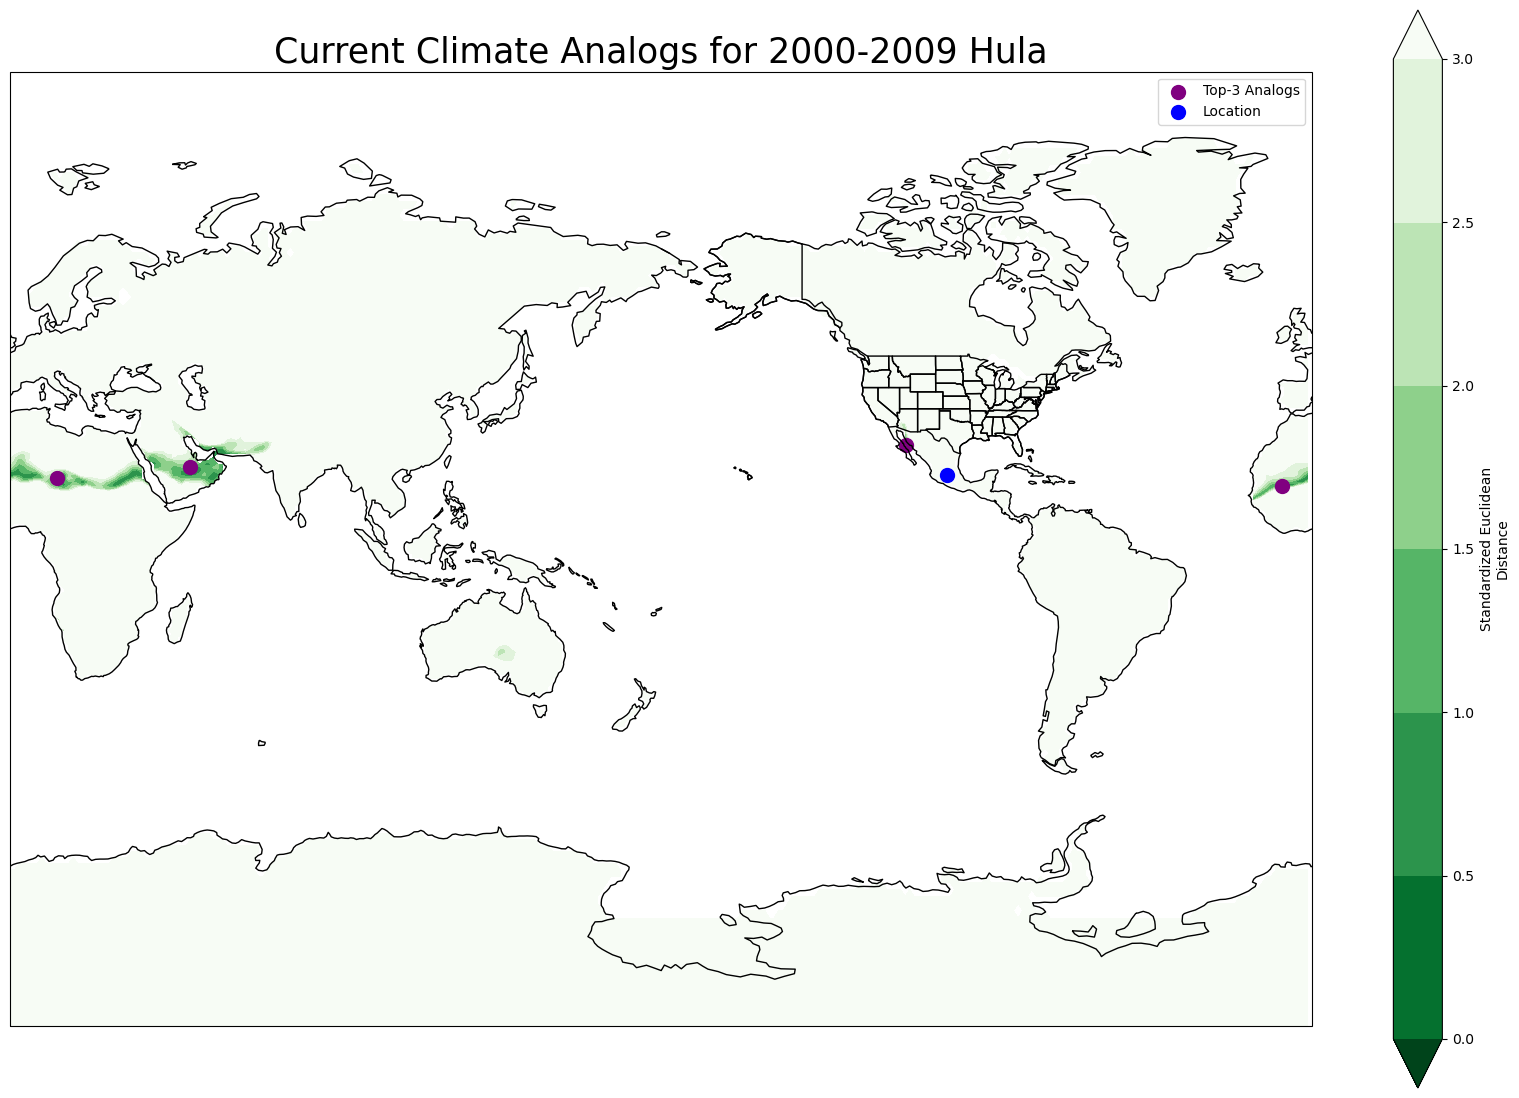

[(49.767156862745054, 22.34986148161045), (351.7045454545455, 17.306044621901076), (12.872807017543806, 19.4516395769621), (247.8125, 28.0366492271423)]


In [129]:
# plot
plt.figure(figsize=(21,14))
ax = plt.axes(projection=ccrs.Miller(central_longitude=180))
contours = da.plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
    cmap=cmap, vmin=vmin, vmax=vmax, extend='both')
if cbar_ylabel:
    contours.colorbar.ax.set_ylabel(cbar_ylabel)
plt.title(title, size=25)
ax.set_global(); ax.coastlines(); ax.add_feature(cartopy.feature.STATES)

#plot points
if top_k:  
    ax.scatter([a[0] for a in top_k],[a[1] for a in top_k],
        transform=ccrs.PlateCarree(), color='purple',
        s=100, label = "Top-{} Analogs".format(k))
ax.scatter(*(location), transform=ccrs.PlateCarree(),
    color='blue', s=100, label="Location")
ax.legend()
plt.show()
print (top_k)

             lat     lon  Standardized Euclidean Distance
0     -90.000000    0.00                        36.365845
1     -90.000000    1.25                        36.285984
2     -90.000000    2.50                        36.281197
3     -90.000000    3.75                        36.278149
4     -90.000000    5.00                        36.366158
...          ...     ...                              ...
18473  83.403145  327.50                        23.556850
18474  83.403145  328.75                        23.543150
18475  83.403145  330.00                        23.494827
18476  83.403145  331.25                        23.432343
18477  83.403145  332.50                        23.290562

[18478 rows x 3 columns]


Text(0, 0.5, 'Lat')

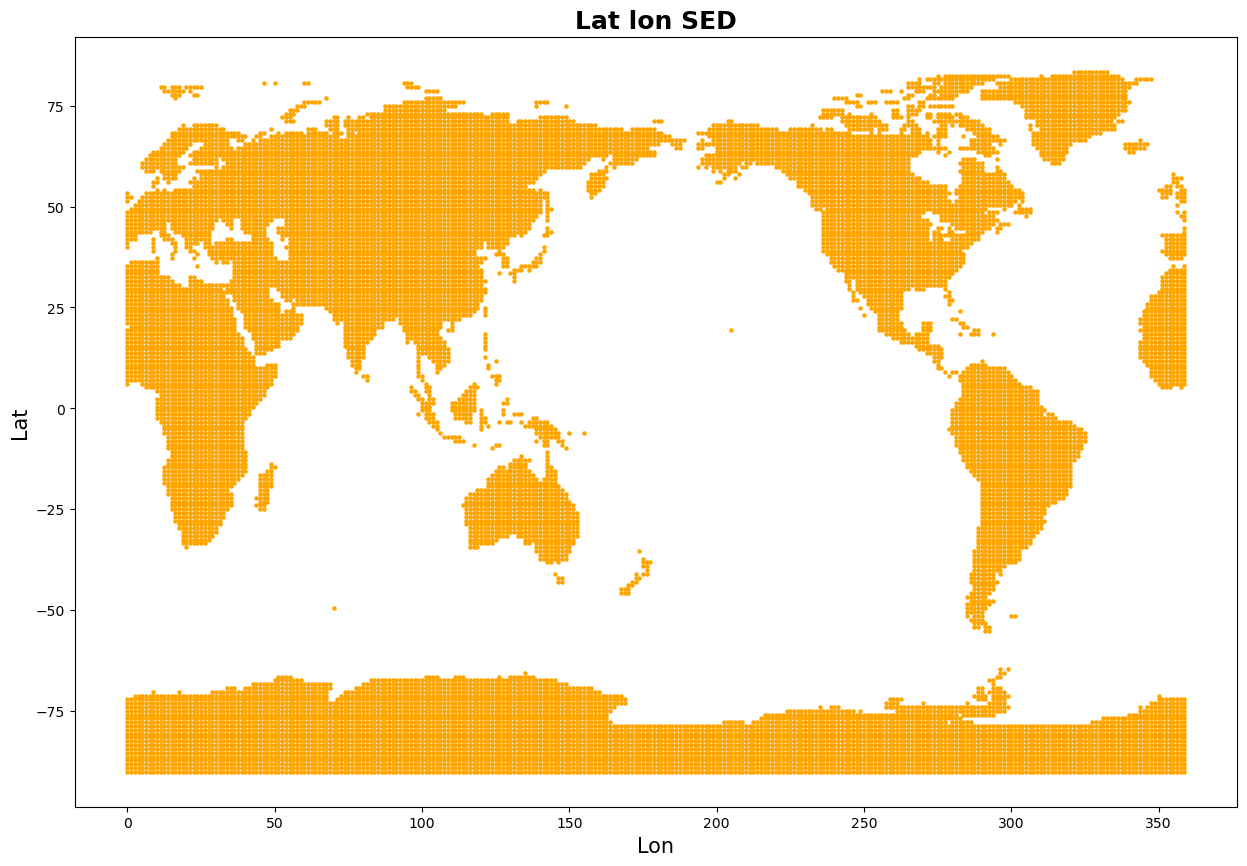

In [70]:
print(df)
from sklearn.cluster import KMeans
plt.style.use('default')
x=np.array(df['lon'])
y=np.array(df['lat'])
plt.figure(figsize=(15, 10))
plt.scatter(x, y, s=5, cmap='viridis',c='orange',label='Analogs')
plt.title('Lat lon SED',fontsize=18, fontweight='bold')
plt.xlabel('Lon',fontsize=15)
plt.ylabel('Lat',fontsize=15)

In [78]:
kmeans = KMeans(n_clusters=3, random_state=0, max_iter=1000)
X = np.array(
    df.drop(['Standardized Euclidean Distance'], 1).astype(float))
Y = np.array(
    df['Standardized Euclidean Distance'].astype(float))

In [79]:
wt_kmeansclus = kmeans.fit(X,sample_weight = Y)
predicted_kmeans = kmeans.predict(X, sample_weight = Y)

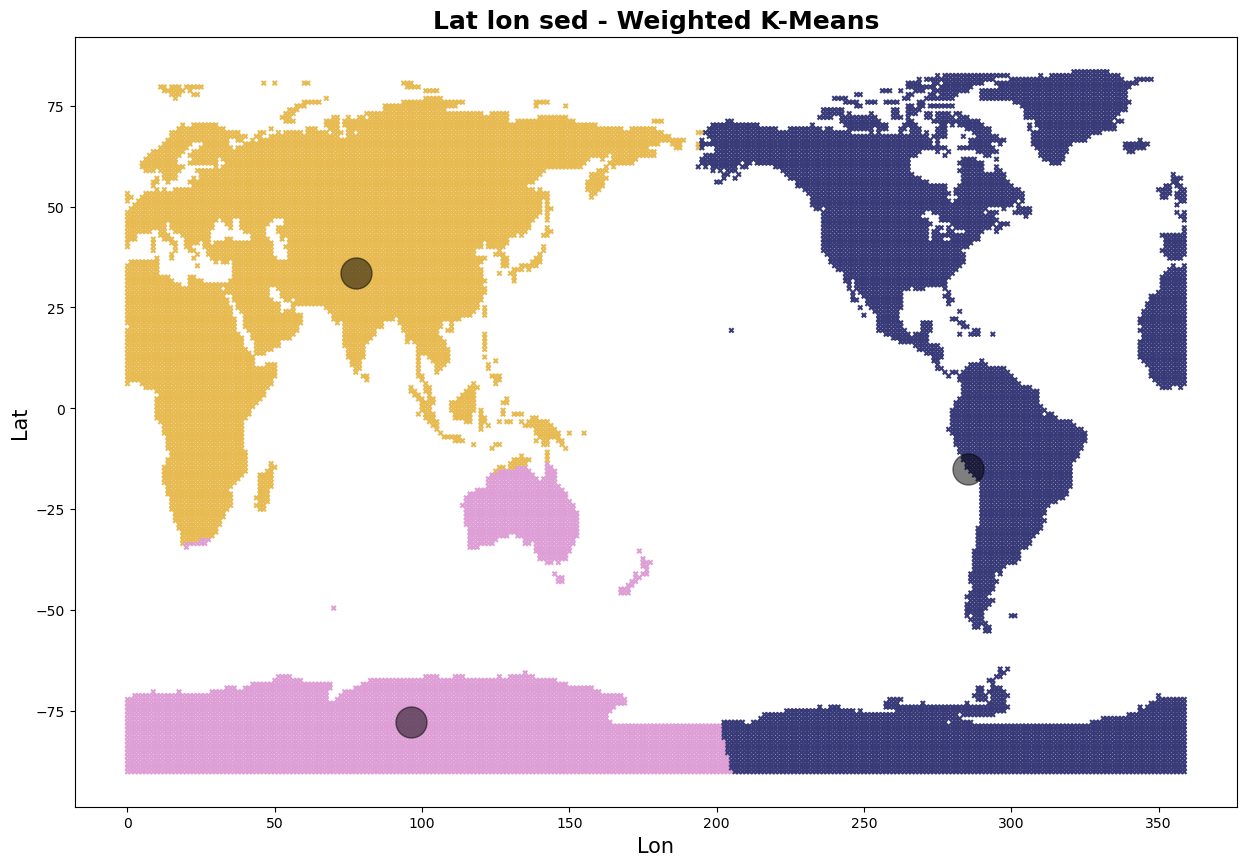

In [80]:
plt.style.use('default')
plt.figure(figsize=(15, 10))
plt.scatter(X[:,1], X[:,0], c=wt_kmeansclus.labels_.astype(float),s=10,cmap='tab20b',marker='x')
plt.title('Lat lon sed - Weighted K-Means',fontsize=18, fontweight='bold')
plt.xlabel('Lon',fontsize=15)
plt.ylabel('Lat',fontsize=15)
centers = wt_kmeansclus.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 0], c='black', s=500, alpha=0.5);

In [55]:
print(df['Standardized Euclidean Distance'].to_numpy())

[36.365845 36.285984 36.281197 ... 23.494827 23.432343 23.290562]


In [88]:
print(df['Standardized Euclidean Distance'])

0        36.365845
1        36.285984
2        36.281197
3        36.278149
4        36.366158
           ...    
18473    23.556850
18474    23.543150
18475    23.494827
18476    23.432343
18477    23.290562
Name: Standardized Euclidean Distance, Length: 18478, dtype: float32


In [93]:
import pandas as pd
from sklearn import preprocessing

x = df[['Standardized Euclidean Distance']].values #returns a numpy array

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df['Standardized Euclidean Distance'] = pd.DataFrame(x_scaled)
print(df)


             lat     lon  Standardized Euclidean Distance
0     -90.000000    0.00                         0.342227
1     -90.000000    1.25                         0.341467
2     -90.000000    2.50                         0.341422
3     -90.000000    3.75                         0.341393
4     -90.000000    5.00                         0.342230
...          ...     ...                              ...
18473  83.403145  327.50                         0.220329
18474  83.403145  328.75                         0.220199
18475  83.403145  330.00                         0.219739
18476  83.403145  331.25                         0.219144
18477  83.403145  332.50                         0.217795

[18478 rows x 3 columns]


In [120]:
print(df)

             lat     lon  ClusterID_unwt
9062   13.664922  343.75               1
9136   14.607329  345.00               1
9137   14.607329  346.25               1
9211   15.549738  346.25               1
9212   15.549738  347.50               1
...          ...     ...             ...
10438  27.801046   58.75               0
10447  27.801046   70.00               0
10725  29.685863  247.50               1
10789  30.628273   50.00               0
10847  30.628273  247.50               1

[185 rows x 3 columns]


In [109]:
df['temp'] = ""
df.loc[df['Standardized Euclidean Distance'] > df['Standardized Euclidean Distance'].quantile(0.1), 'temp'] = np.nan
df.loc[df['Standardized Euclidean Distance'] < df['Standardized Euclidean Distance'].quantile(0.1), 'temp'] = 1
print(df['Standardized Euclidean Distance'].quantile(0.1))


df = df.dropna()
df = df.drop(columns=['Standardized Euclidean Distance','temp'])
print(df)

0.012230644188821317
             lat     lon
9062   13.664922  343.75
9136   14.607329  345.00
9137   14.607329  346.25
9211   15.549738  346.25
9212   15.549738  347.50
...          ...     ...
10438  27.801046   58.75
10447  27.801046   70.00
10725  29.685863  247.50
10789  30.628273   50.00
10847  30.628273  247.50

[185 rows x 2 columns]


             lat     lon
9062   13.664922  343.75
9136   14.607329  345.00
9137   14.607329  346.25
9211   15.549738  346.25
9212   15.549738  347.50
...          ...     ...
10438  27.801046   58.75
10447  27.801046   70.00
10725  29.685863  247.50
10789  30.628273   50.00
10847  30.628273  247.50

[185 rows x 2 columns]


Text(0, 0.5, 'Lat')

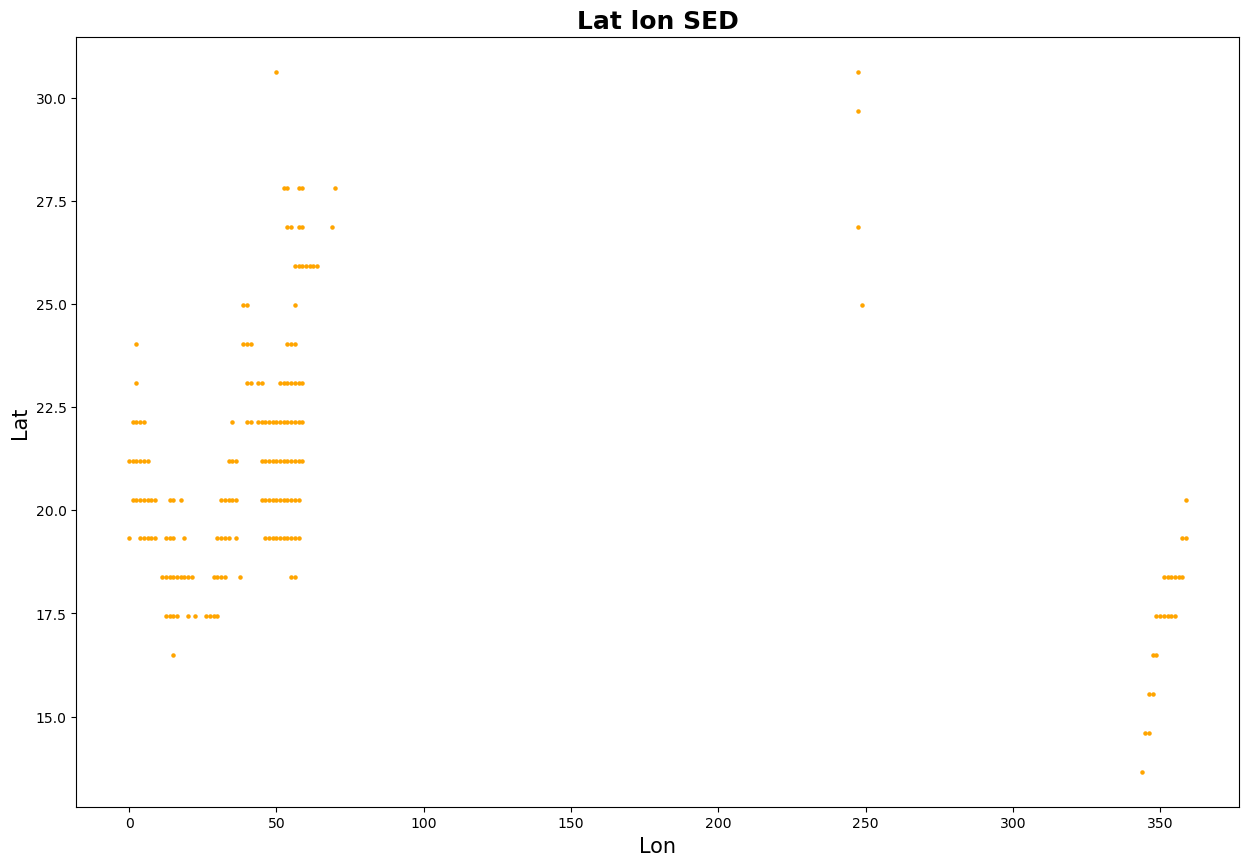

In [110]:
print(df)
from sklearn.cluster import KMeans
plt.style.use('default')
x=np.array(df['lon'])
y=np.array(df['lat'])
plt.figure(figsize=(15, 10))
plt.scatter(x, y, s=5, cmap='viridis',c='orange',label='Analogs')
plt.title('Lat lon SED',fontsize=18, fontweight='bold')
plt.xlabel('Lon',fontsize=15)
plt.ylabel('Lat',fontsize=15)

In [124]:
df = df.drop(['ClusterID_unwt'], 1)
X = np.array(df.astype(float))
print(X)
print(df)

[[ 13.66492176 343.75      ]
 [ 14.60732937 345.        ]
 [ 14.60732937 346.25      ]
 [ 15.54973793 346.25      ]
 [ 15.54973793 347.5       ]
 [ 16.49214745  15.        ]
 [ 16.49214745 347.5       ]
 [ 16.49214745 348.75      ]
 [ 17.43455505  12.5       ]
 [ 17.43455505  13.75      ]
 [ 17.43455505  15.        ]
 [ 17.43455505  16.25      ]
 [ 17.43455505  20.        ]
 [ 17.43455505  22.5       ]
 [ 17.43455505  26.25      ]
 [ 17.43455505  27.5       ]
 [ 17.43455505  28.75      ]
 [ 17.43455505  30.        ]
 [ 17.43455505 348.75      ]
 [ 17.43455505 350.        ]
 [ 17.43455505 351.25      ]
 [ 17.43455505 352.5       ]
 [ 17.43455505 353.75      ]
 [ 17.43455505 355.        ]
 [ 18.37696266  11.25      ]
 [ 18.37696266  12.5       ]
 [ 18.37696266  13.75      ]
 [ 18.37696266  15.        ]
 [ 18.37696266  16.25      ]
 [ 18.37696266  17.5       ]
 [ 18.37696266  18.75      ]
 [ 18.37696266  20.        ]
 [ 18.37696266  21.25      ]
 [ 18.37696266  28.75      ]
 [ 18.37696266

In [125]:
kmeans = KMeans(n_clusters=4, random_state=0,max_iter=1000)
kmeansclus_nw = kmeans.fit(df)
predicted_kmeans_nw = kmeans.predict(X)
centers_nw = kmeansclus_nw.cluster_centers_

df['ClusterID_unwt'] = predicted_kmeans_nw
centersdf_nw=pd.DataFrame(centers_nw)
centersdf_nw['ClusterID_unwt'] = centersdf_nw.index
centersdf_nw=centersdf_nw.rename(columns = {0:'Unwt Centroid: Spend in Local',1:'Unwt Centroid: Spend in Organic'})
df_nw=df.merge(centersdf_nw,on='ClusterID_unwt',how='left')
df_nw.head()

lat     lon  ClusterID_unwt  Unwt Centroid: Spend in Local  \
0  13.664922  343.75               1                      17.306045   
1  14.607329  345.00               1                      17.306045   
2  14.607329  346.25               1                      17.306045   
3  15.549738  346.25               1                      17.306045   
4  15.549738  347.50               1                      17.306045   

   Unwt Centroid: Spend in Organic  
0                       351.704545  
1                       351.704545  
2                       351.704545  
3                       351.704545  
4                       351.704545

Text(0, 0.5, 'Spend_in_Organic')

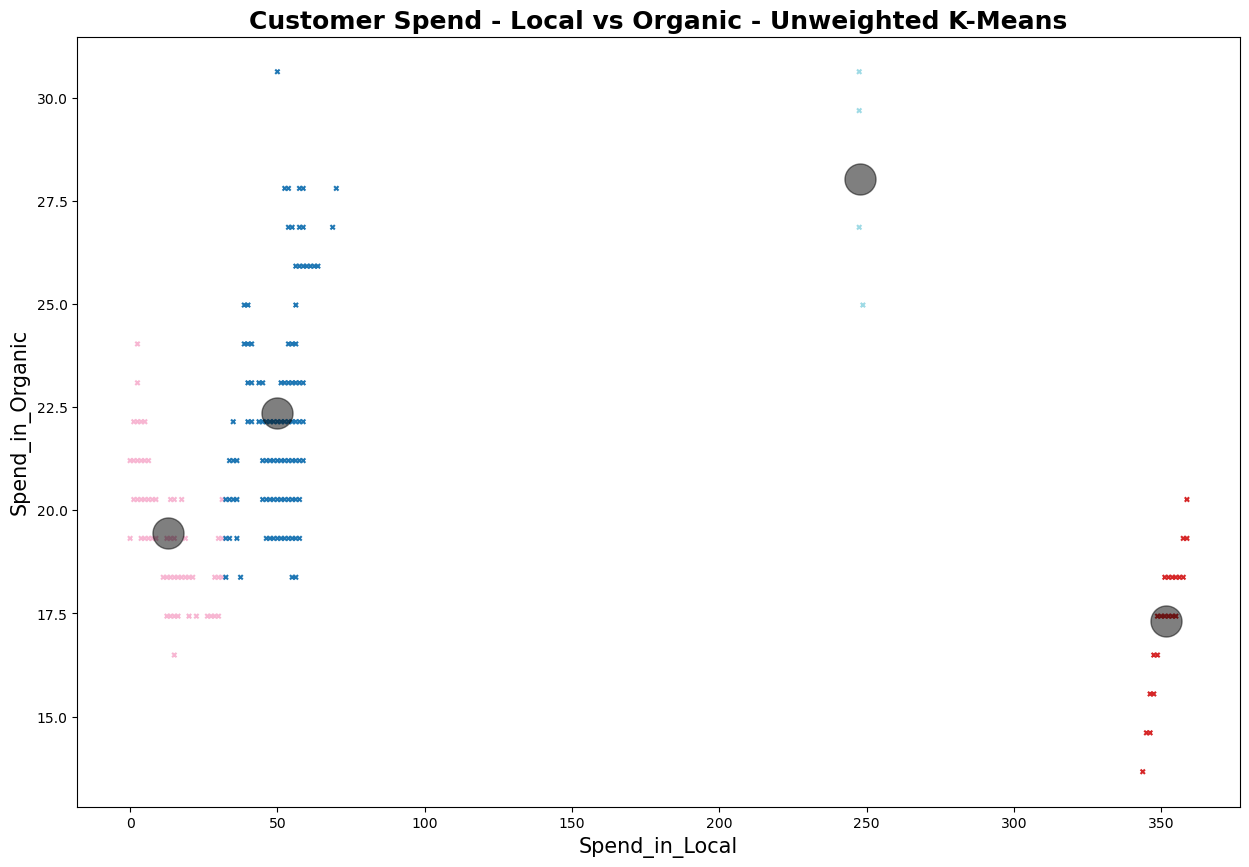

In [126]:
plt.figure(figsize=(15, 10))
plt.scatter(X[:, 1], X[:, 0], c=predicted_kmeans_nw, s=10, cmap='tab20',marker ='x')
plt.scatter(centers_nw[:, 1], centers_nw[:, 0], c='black', s=500, alpha=0.5);plt.title('Customer Spend - Local vs Organic - Unweighted K-Means',fontsize=18, fontweight='bold')
plt.xlabel('Spend_in_Local',fontsize=15)
plt.ylabel('Spend_in_Organic',fontsize=15)

In [127]:
print(centers_nw)

[[ 22.34986148  49.76715686]
 [ 17.30604462 351.70454545]
 [ 19.45163958  12.87280702]
 [ 28.03664923 247.8125    ]]


In [128]:
top_k=[(p[1], p[0]) for p in centers_nw]
print(top_k)

[(49.767156862745054, 22.34986148161045), (351.7045454545455, 17.306044621901076), (12.872807017543806, 19.4516395769621), (247.8125, 28.0366492271423)]
